In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

In [9]:
eigenvalue_file_path = r"C:\Users\sulta\git\cone-operator-lab\mathematica\ellipsoid_eigs_a1_b1.5_c2.3_arnoldi-1000.txt"

eigs_all = np.loadtxt(eigenvalue_file_path, dtype=float)

eigs_index_range = (0, 1000)  # Mathematica [1,400]
target_eigs = eigs_all[eigs_index_range[0] : eigs_index_range[1]]
num_eigs = target_eigs.size

print("Subintervall:", eigs_index_range)
print("Genutzte Eigenwerte (N):", num_eigs)
print("Erster Eigenwert im Fit:", target_eigs[0])
print("Letzter Eigenwert im Fit:", target_eigs[-1])

Subintervall: (0, 1000)
Genutzte Eigenwerte (N): 1000
Erster Eigenwert im Fit: 5.3046763751642265
Letzter Eigenwert im Fit: 287.2887836988918


In [10]:
def fit_weyl_3_ridge(eigs, frac_range=(0.2, 0.9), alpha=1e-6):
    eigs = np.asarray(eigs, dtype=float)
    n = eigs.size

    r1, r2 = frac_range
    k_min = math.ceil(r1 * n)
    k_max = math.floor(r2 * n)

    lam = eigs[k_min-1 : k_max]
    k_vals = np.arange(k_min, k_max + 1, dtype=float)

    # Designmatrix: [λ^(3/2), λ, sqrt(λ)]
    X = np.column_stack([lam**1.5, lam, np.sqrt(lam)])

    # Ridge-Regression: (X^T X + alpha I)^{-1} X^T y
    model = Ridge(alpha=alpha, fit_intercept=False)
    model.fit(X, k_vals)
    # model.coef_ = [A0, A1, A2]
    return model.coef_

In [11]:
fit_frac_range_main = (0.2, 0.9)
lambda_reg = 1e-6

A0, A1, A2 = fit_weyl_3_ridge(
    target_eigs,
    frac_range=fit_frac_range_main,
    alpha=lambda_reg
)

vol_spec = 6.0 * np.pi**2 * A0

# Wahres Volumen
trueA, trueB, trueC = 1.0, 1.5, 2.3
vol_true = 4.0 * np.pi / 3.0 * trueA * trueB * trueC
rel_error = abs(vol_spec - vol_true) / vol_true

print()
print("--- 3-Term-Weyl-Fit mit Ridge (sklearn) ---")
print("Fenster (k/N):", fit_frac_range_main)
print("A0:", A0)
print("A1:", A1)
print("A2:", A2)
print("Volumen (aus Spektrum, 3-Term):", vol_spec)
print("Volumen (geometrisch):         ", vol_true)
print("Relativer Fehler:              ", rel_error)


--- 3-Term-Weyl-Fit mit Ridge (sklearn) ---
Fenster (k/N): (0.2, 0.9)
A0: 0.23467190906883342
A1: -0.47585029779553717
A2: -0.3691692792847113
Volumen (aus Spektrum, 3-Term): 13.896713439346799
Volumen (geometrisch):          14.451326206513047
Relativer Fehler:               0.0383779840853838


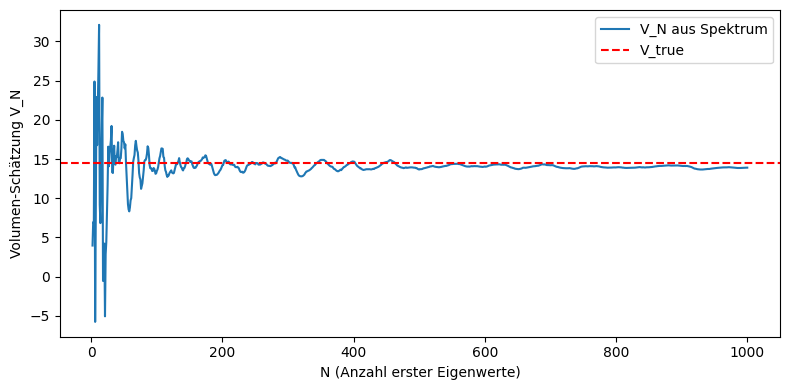

In [12]:
maxN = num_eigs

def vol_from_first_m(m):
    eigs_sub = target_eigs[:m]
    A0_sub, _, _ = fit_weyl_3_ridge(
        eigs_sub,
        frac_range=fit_frac_range_main,
        alpha=lambda_reg
    )
    return 6.0 * np.pi**2 * A0_sub

vol_conv_data = np.array(
    [(m, vol_from_first_m(m)) for m in range(2, maxN + 1)],
    dtype=float
)

plt.figure(figsize=(8, 4))
plt.plot(vol_conv_data[:, 0], vol_conv_data[:, 1], label="V_N aus Spektrum")
plt.axhline(vol_true, color="red", linestyle="--", label="V_true")
plt.xlabel("N (Anzahl erster Eigenwerte)")
plt.ylabel("Volumen-Schätzung V_N")
plt.legend()
plt.tight_layout()
plt.show()